In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def visualize(tensor, title):

  detached_tensor = tensor.cpu().detach()
  
  image_grid = make_grid(detached_tensor, nrow=8)
  
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.title(title)
  plt.show()

## Dataset

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from PIL import Image
from torch.utils.data import Subset

In [5]:
lr = 0.001
batch_size = 16
beta1 = 0
beta2 = 0.99
criterion = nn.BCELoss()
c_lambda = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [6]:
# class CelebA(Dataset):
  
#   def __init__(self, root, transform=None):
#     self.files = glob.glob(os.path.join(root, "*.jpg"))
#     self.transform = transform

#   def __getitem__(self, index):

#     image = Image.open(self.files[index]) 

#     if self.transform is not None:
#       return self.transform(image)
    
#     return image

#   def __len__(self):
#     return len(self.files)

In [ ]:
# len(os.listdir("/content/drive/MyDrive/haircolors/images/img_align_celeba/"))

In [7]:
def loaderFunc(transform):
  
  # ds = CIFAR10('~/.torch/data/', train=True, download=True, transform=transform)
  # dog_indices, deer_indices, other_indices = [], [], []
  # dog_idx, deer_idx = ds.class_to_idx['dog'], ds.class_to_idx['airplane']

  # for i in range(len(ds)):
  #   current_class = ds[i][1]
  #   if current_class == dog_idx:
  #     dog_indices.append(i)
  #   elif current_class == deer_idx:
  #     deer_indices.append(i)
  #   else:
  #     other_indices.append(i)
  # dog_indices = dog_indices[:int(0.6 * len(dog_indices))]
  # deer_indices = deer_indices[:int(0.6 * len(deer_indices))]
  # new_dataset = Subset(ds, deer_indices)
  
  # dataset = CelebA("/content/drive/MyDrive/haircolors/images/img_align_celeba/", transform=transform)
  dataset = CIFAR10('~/.torch/data/', train=True, download=True, transform=transform)

  train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
  )

  return train_loader

In [8]:
def sample_data(image_size=4):

  transform = transforms.Compose([
      transforms.Resize(image_size),
      transforms.CenterCrop(image_size),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])


  loader = loaderFunc(transform)

  for img, label in loader:
      yield (img, label)

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/06/Tables-Showing-Generator-and-Discriminator-Configuration-for-the-Progressive-Growing-GAN.png"  width="1024"/>

In [9]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        # assuming input is in the from of (batch_size, channels, width, height)
        return input / torch.sqrt(torch.mean(input ** 2, dim=1, keepdim=True)
                                  + 1e-8)

In [10]:
from math import sqrt 
def EqualLR(module, input):

  weight = getattr(module, 'weight')
  del module._parameters['weight']
  weight = weight * sqrt(2 / (weight.size(1) * weight[0][0].numel()))
  module.register_parameter("weight", nn.Parameter(weight.data))
  return input

In [11]:
class EqualConv2d(nn.Module):
  
  def __init__(self, *args, **kwargs):
    
    super().__init__()

    self.conv = nn.Conv2d(*args, **kwargs)
    self.conv.register_forward_pre_hook(EqualLR)

  def forward(self, x):
    return self.conv(x)

In [12]:
def GeneratorBlock(in_channel, out_channel, output_size, first_block=False):
  # Growing gradually to 1024 * 1024 is done by incrementally adding blocks
  # in this function we get specification of the block and return it
  # for example input would be 4 * 4 and output_size would be 8 * 8
  if first_block:

    model = nn.Sequential(
      EqualConv2d(in_channel, out_channel, kernel_size=4, padding=3),
      nn.LeakyReLU(0.2),
      PixelNorm(),

      EqualConv2d(out_channel, out_channel, kernel_size=3, padding=1),
      nn.LeakyReLU(0.2),
      PixelNorm(),
    )
  else:

    model = nn.Sequential(
    
      nn.Upsample((output_size, output_size), mode='bilinear', align_corners=True),
      EqualConv2d(in_channel, out_channel, kernel_size=3, padding=1),
      nn.LeakyReLU(0.2),
      PixelNorm(),

      EqualConv2d(out_channel, out_channel, kernel_size=3, padding=1),
      nn.LeakyReLU(0.2),
      PixelNorm(),
    )

  return model  

In [13]:
class Generator(nn.Module):

  def __init__(self):
    
    super().__init__()

    self.block4_4 = GeneratorBlock(512, 512, 4, first_block=True)
    self.block8_8 = GeneratorBlock(512, 512, 8)
    self.block16_16 = GeneratorBlock(512, 512, 16)
    self.block32_32 = GeneratorBlock(512, 512, 32)
    self.block64_64 = GeneratorBlock(512, 256, 64)
    self.block128_128 = GeneratorBlock(256, 128, 128)

    self.blocks = nn.ModuleList([
        self.block4_4,
        self.block8_8,
        self.block16_16,
        self.block32_32,
        self.block64_64,
        self.block128_128
    ])

    self.to_rgbs = nn.ModuleList([
      nn.Conv2d(512, 3, 1),
      nn.Conv2d(512, 3, 1),
      nn.Conv2d(512, 3, 1),
      nn.Conv2d(512, 3, 1),
      nn.Conv2d(256, 3, 1),
      nn.Conv2d(128, 3, 1),
    ])


  def forward(self, x, step, alpha):
    # we have six steps toward progressively increasing the output size
    # alpha is the weight of output of new block compared to upsampled input
    if step == 1: # no need to average
      out = self.blocks[0](x)
      out = self.to_rgbs[0](out)

    elif step > 1:

      for block in self.blocks[:step - 1]: # assuming all previous blocks have been trained completely
        x = block(x)

      # x_small_block = self.blocks[step-2](x) # 256 * 64 * 64
      # x is 16 * 512 * 16 * 16
      x_large_block = self.blocks[step-1](x) # 128 * 128 * 128
      x_large_image = self.to_rgbs[step-1](x_large_block) # 3 * 128 * 128


      x_small_upsample = F.interpolate(x, x_large_image.shape[-2:]) # 3 * 64 * 64
      x_upsample_rgb = self.to_rgbs[step-2](x_small_upsample)

      out = (alpha *  x_large_image) + (1 - alpha) * (x_upsample_rgb)


    return out


In [14]:
gen = Generator().to(device)

In [15]:
gen(torch.randn(16, 512, 1, 1).to(device), 4, 0.2).shape

torch.Size([16, 3, 32, 32])

In [16]:
def DiscriminatorBlock(in_channel, out_channel, output_size, last_block=False):
  # Growing gradually to 1024 * 1024 is done by incrementally adding blocks
  # in this function we get specification of the block and return it
  # for example input would be 4 * 4 and output_size would be 8 * 8
  if last_block:

    model = nn.Sequential(
      nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
      nn.LeakyReLU(0.2),

      nn.Conv2d(out_channel, out_channel, kernel_size=4, padding=0),
      nn.LeakyReLU(0.2),
      nn.Flatten(start_dim=1),
      nn.Linear(512, 1),
    )
  else:

    model = nn.Sequential(
    
      EqualConv2d(in_channel, out_channel, kernel_size=3, padding=1),
      PixelNorm(),
      nn.LeakyReLU(0.2),

      EqualConv2d(out_channel, out_channel, kernel_size=3, padding=1),
      PixelNorm(),
      nn.LeakyReLU(0.2),

      nn.AvgPool2d(kernel_size=2),
    )

  return model

In [17]:
class Discriminator(nn.Module):

  def __init__(self):
    
    super().__init__()

    self.block64_64 = DiscriminatorBlock(128, 256, 64)
    self.block32_32 = DiscriminatorBlock(256, 512, 32)
    self.blcok16_16 = DiscriminatorBlock(512, 512, 16)
    self.block8_8 = DiscriminatorBlock(512, 512, 8)
    self.block4_4 = DiscriminatorBlock(512, 512, 4)
    self.block1_1 = DiscriminatorBlock(512, 512, 1, last_block=True)

    self.blocks = nn.ModuleList([
      self.block64_64,
      self.block32_32,
      self.blcok16_16,
      self.block8_8,
      self.block4_4,
      self.block1_1
    ])

    self.from_rgbs = nn.ModuleList([
      nn.Conv2d(3, 128, 1),
      nn.Conv2d(3, 256, 1),
      nn.Conv2d(3, 512, 1),
      nn.Conv2d(3, 512, 1),
      nn.Conv2d(3, 512, 1),
      nn.Conv2d(3, 512, 1),
    ])
  

  def forward(self, x_large, step, alpha):
    
    if step == 1:
      out = self.from_rgbs[-step](x_large)
      out = self.blocks[-step](out)
    
    elif step > 1:
      
      x_large_feature_map = self.from_rgbs[(6-step)](x_large) # input : 3 * 8 * 8 and output is 512 * 8 * 8
      x_small = self.blocks[-step](x_large_feature_map) # last layer output is 512 * 4 * 4
      
      # x_large_downsampled = F.avg_pool2d(self.from_rgbs[(6 - step) + 1](x_large), kernel_size=2) # input 3 * 8 * 8 => output is 512 * 8 * 8 => downsampled to 512 * 4 * 4
      x_large_downsampled = self.from_rgbs[(6 - step) + 1](F.avg_pool2d(x_large, kernel_size=2)) # input 3 * 8 * 8 => 3 * 4 *4  and then from rgb to 512 * 4 *4 

      out = (1 - alpha) * x_large_downsampled + (alpha * x_small)

      for block in self.blocks[(6 - step) + 1:]:
        out = block(out)
    
    return out

In [18]:
disc = Discriminator().to(device)

In [19]:
gen_optim = torch.optim.Adam(gen.parameters(), lr=lr , betas=(beta1, beta2))
disc_optim = torch.optim.Adam(disc.parameters(), lr=lr , betas=(beta1, beta2))

In [20]:
from tqdm.auto import tqdm

In [21]:
def gradient_penalty(real, fake, epsilon, step, alpha):
  
  mixed_images = epsilon * real + (1 - epsilon) * fake
  mixed_scores = disc(mixed_images, step, alpha)

  gradients = torch.autograd.grad(
      outputs=mixed_scores,
      inputs=mixed_images,
      grad_outputs=torch.ones_like(mixed_scores),
      retain_graph=True,
      create_graph=True,
  )[0]

  flat_gradients = gradients.reshape(len(gradients), -1)

  norm = torch.norm(flat_gradients, dim=1)

  gp = torch.mean((norm - 1) ** 2)

  return gp

In [22]:
# step and alpha
step = 1
step_size = 0.00002
alpha = 0
latent_space_size = 512
epoch_t = 0

In [23]:
# pred_real = disc(real, step, alpha)
# real.shape
step

1

In [24]:
import numpy as np
disc_loss_list = []
gen_loss_list = []

In [26]:
ckpt = torch.load("/content/drive/MyDrive/progressive_gan_checkpoints/cpt_step_4_epoch_18_iteration_0")
disc.load_state_dict(ckpt["disc_model"])
gen.load_state_dict(ckpt["gen_model"])
disc_optim.load_state_dict(ckpt["disc_optim"])
gen_optim.load_state_dict(ckpt["gen_optim"])
epoch_t = ckpt["epoch"]
alpha = ckpt["alpha"]
step = ckpt["step"]

0it [00:00, ?it/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/.torch/data/cifar-10-python.tar.gz to /root/.torch/data/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


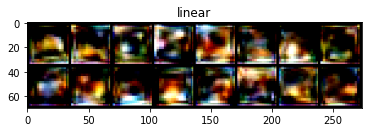

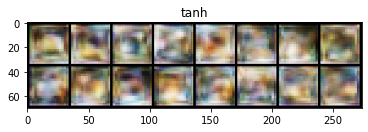

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


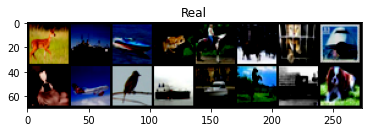

alpha is 0.06321999999999801
step is 4
Gen Loss 343.99560546875
Disc Loss -8.676485061645508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


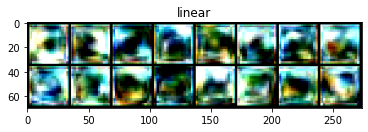

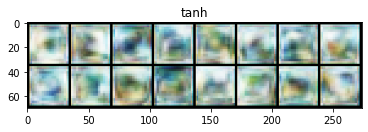

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


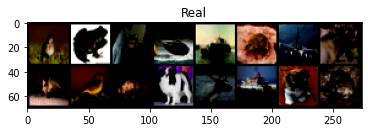

alpha is 0.08322000000000414
step is 4
Gen Loss 334.01498570666087
Disc Loss -7.445541722612543


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


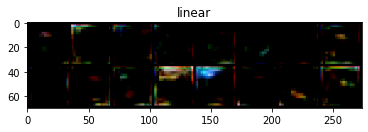

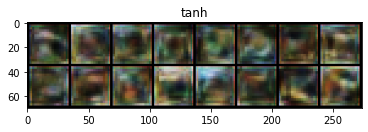

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


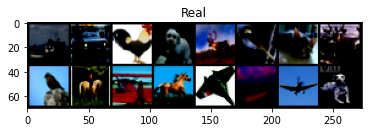

alpha is 0.10322000000001026
step is 4
Gen Loss 208.90179173020587
Disc Loss -7.582353172720461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


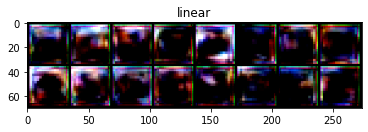

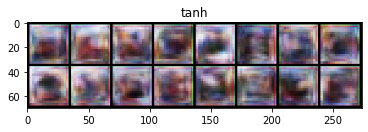

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


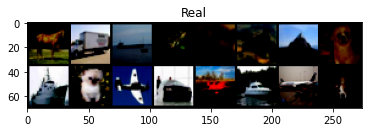

alpha is 0.12322000000001639
step is 4
Gen Loss 152.3789753267765
Disc Loss -7.718901937623818


0it [00:00, ?it/s]

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


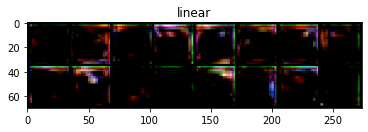

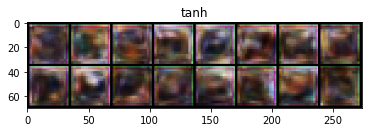

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


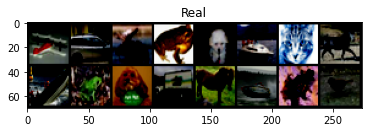

alpha is 0.12572000000001665
step is 4
Gen Loss 124.94928600049019
Disc Loss -7.727834518829981


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


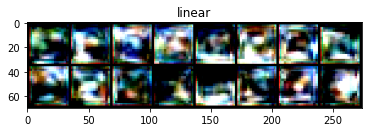

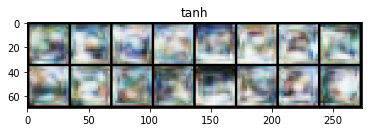

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


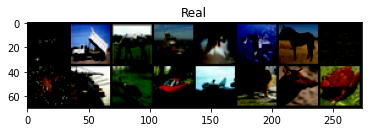

alpha is 0.1457200000000089
step is 4
Gen Loss 21.192106020748614
Disc Loss -7.955011643012365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


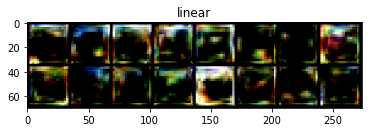

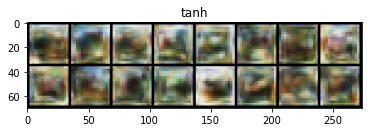

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


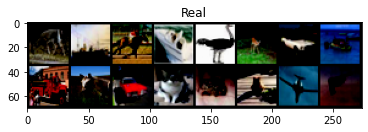

alpha is 0.16572000000000114
step is 4
Gen Loss 48.00524872714281
Disc Loss -8.0771252019008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


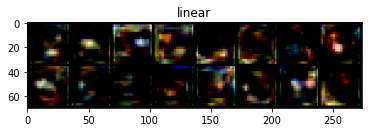

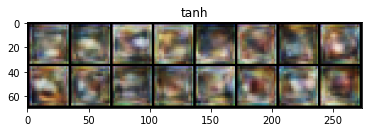

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


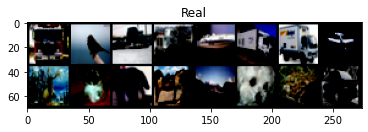

alpha is 0.1857199999999934
step is 4
Gen Loss 75.44033539611101
Disc Loss -8.186480263352394


0it [00:00, ?it/s]

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


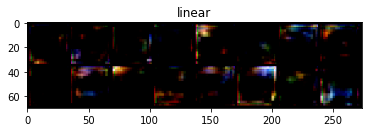

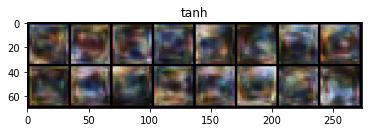

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


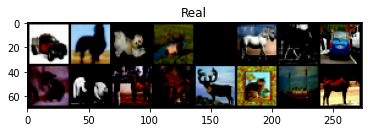

alpha is 0.18821999999999242
step is 4
Gen Loss 67.18408315799634
Disc Loss -8.185755883495013


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


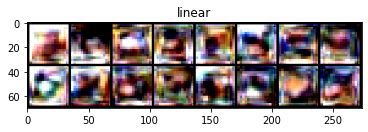

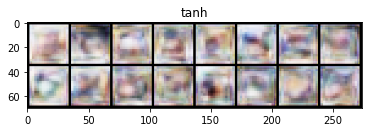

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


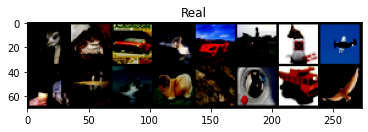

alpha is 0.20821999999998467
step is 4
Gen Loss 156.88671060995262
Disc Loss -8.271122283438842


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


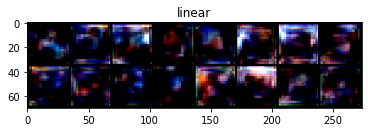

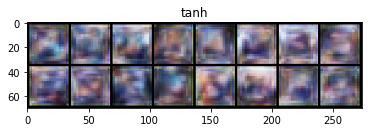

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


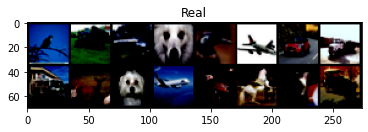

alpha is 0.2282199999999769
step is 4
Gen Loss 272.1426929906607
Disc Loss -8.348281286656857


In [ ]:
for epoch in range(epoch_t, 100):

  for iteration, (real, _) in enumerate(tqdm(sample_data(2 ** (step + 1)))):

    real = real.to(device)

    if step <= 4 and alpha < 1:
      alpha += step_size

    if alpha > 1 and step < 4:
      step += 1
      alpha = 0
      continue # adjust the batch size images 

    # Training Discriminator
    disc_optim.zero_grad()

    fake = gen(torch.randn(len(real), latent_space_size, 1, 1).to(device), step, alpha).detach()
    pred_fake = disc(fake, step, alpha)

    pred_real = disc(real, step, alpha)

    epsilon = torch.randn(len(real), 1, 1, 1, requires_grad=True).to(device)

    gp = gradient_penalty(real, fake, epsilon, step, alpha)

    disc_loss = - torch.mean(pred_real - pred_fake) + (c_lambda * gp)

    disc_loss.backward()

    disc_optim.step()

     # Training Generator
    gen_optim.zero_grad()

    fake = gen(torch.randn(batch_size, latent_space_size, 1, 1).to(device), step, alpha)
    pred_fake = disc(fake, step, alpha).reshape(-1)
    gen_loss = - torch.mean(pred_fake)

    gen_loss.backward()

    gen_optim.step()


    disc_loss_list.append(disc_loss.item())
    gen_loss_list.append(gen_loss.item())

    if iteration % 1000 == 0:
      
      visualize(fake, "linear")
      visualize((torch.tanh(fake) + 1) / 2, "tanh")
      visualize(real, "Real")
      
      print("alpha is", alpha)
      print("step is", step)
      print("Gen Loss", np.mean(gen_loss_list[-3000:]))
      print("Disc Loss", np.mean(disc_loss_list[-3000:]))

    
    if iteration % 2000 == 0:
      torch.save({
          "gen_model": gen.state_dict(),
          "gen_optim": gen_optim.state_dict(),
          "disc_model": disc.state_dict(),
          "disc_optim": disc_optim.state_dict(),
          "epoch": epoch,
          "iteration": iteration,
          "step": step,
          "alpha": alpha,
      }, "/content/drive/MyDrive/progressive_gan_checkpoints/cpt_step_{}_epoch_{}_iteration_{}".format(step, epoch, iteration))

      